# Neural Network model tuning

## Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.callbacks import ModelCheckpoint



#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
#from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score
#from sklearn.metrics import precision_recall_curve, average_precision_score


In [2]:
from modules.data_exploration.data_ex import import_data, gen_bulk_data, get_bulk_inst
from modules.build_ml_models.NN_classification import build_model, plot_confusion_matrix, print_classification_report

## Load data

In [3]:
file_path = 'data/churn.csv'
data_dict = gen_bulk_data(file_path)
data_dict.keys()

dict_keys(['original', 'dropped', 'scaled', 'encoded', 'encoded and scaled', 'scaled and dropped'])

In [4]:
key = 'original'

x_train, x_test, x_val, y_train, y_test, y_val = get_bulk_inst(data_dict, key)

In [5]:
#x_train.drop(columns=['index'], inplace=True)
#x_test.drop(columns=['index'], inplace=True)
x_train

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,29,80,415,1551,0,0,0,127.8,67,21.73,181.6,112,15.44,197.3,63,8.88,15.9,2,4.29,2
1,23,57,415,1094,0,0,0,272.7,74,46.36,224.9,85,19.12,178.2,104,8.02,10.5,3,2.84,2
2,11,115,415,480,0,1,33,145.0,72,24.65,194.5,157,16.53,242.3,138,10.90,14.2,3,3.83,2
3,4,105,415,4351,0,1,31,109.6,108,18.63,249.3,119,21.19,321.2,101,14.45,8.3,4,2.24,4
4,22,110,510,1591,0,0,0,18.9,92,3.21,258.4,81,21.96,109.6,74,4.93,14.8,4,4.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,1,95,415,3277,0,0,0,194.6,114,33.08,232.8,106,19.79,173.4,92,7.80,3.8,2,1.03,3
3496,43,110,415,207,0,0,0,149.2,128,25.36,112.8,101,9.59,156.3,111,7.03,12.2,4,3.29,1
3497,39,121,510,452,0,1,20,211.9,110,36.02,215.1,120,18.28,238.5,107,10.73,9.4,2,2.54,0
3498,31,123,408,455,0,0,0,159.5,77,27.12,303.8,92,25.82,226.9,120,10.21,12.0,4,3.24,0


In [6]:
#from keras.utils import to_categorical 
#import numpy as np

#y_train_cat = to_categorical(y_train)

#type(y_train_cat)
#print(y_train_cat.shape)
#print(x_train.shape)



#for i in range(len(y_train_cat)):
#    print(y_train_cat[i])


# Build model

## Model with best Recall

In [7]:
from tensorflow.keras.optimizers import Adam

optimizer= Adam(0.0001)

model_rec = build_model(input_shape=20, hidden_shapes=[32], hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')

model_rec.summary()

32
Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


model_rec.compile(
    loss='binary_crossentropy',
    #loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.0005),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.TruePositives()])

In [8]:
epo = 50

CB_checkpoint = ModelCheckpoint(monitor='val_recall', filepath='recall_model.hdf5', save_best_only=True, mode='max',verbose=1)


history_rec = model_rec.fit(x_train, y_train, epochs=epo, validation_split=0.2, callbacks=[CB_checkpoint], verbose=0)


Epoch 00001: val_recall improved from -inf to 0.88119, saving model to recall_model.hdf5

Epoch 00002: val_recall did not improve from 0.88119

Epoch 00003: val_recall did not improve from 0.88119

Epoch 00004: val_recall did not improve from 0.88119

Epoch 00005: val_recall did not improve from 0.88119

Epoch 00006: val_recall did not improve from 0.88119

Epoch 00007: val_recall did not improve from 0.88119

Epoch 00008: val_recall did not improve from 0.88119

Epoch 00009: val_recall did not improve from 0.88119

Epoch 00010: val_recall did not improve from 0.88119

Epoch 00011: val_recall did not improve from 0.88119

Epoch 00012: val_recall did not improve from 0.88119

Epoch 00013: val_recall did not improve from 0.88119

Epoch 00014: val_recall did not improve from 0.88119

Epoch 00015: val_recall did not improve from 0.88119

Epoch 00016: val_recall did not improve from 0.88119

Epoch 00017: val_recall did not improve from 0.88119

Epoch 00018: val_recall did not improve from 

In [9]:
# Load best recall modell
model_rec.load_weights('recall_model.hdf5')

model_rec.evaluate(x_test, y_test)

24/24 [==============================] - 0s 1ms/step - loss: 94.1218 - accuracy: 0.1853 - precision: 0.1388 - recall: 0.9151


[94.12184143066406,
 0.18533332645893097,
 0.13876967132091522,
 0.9150943160057068]

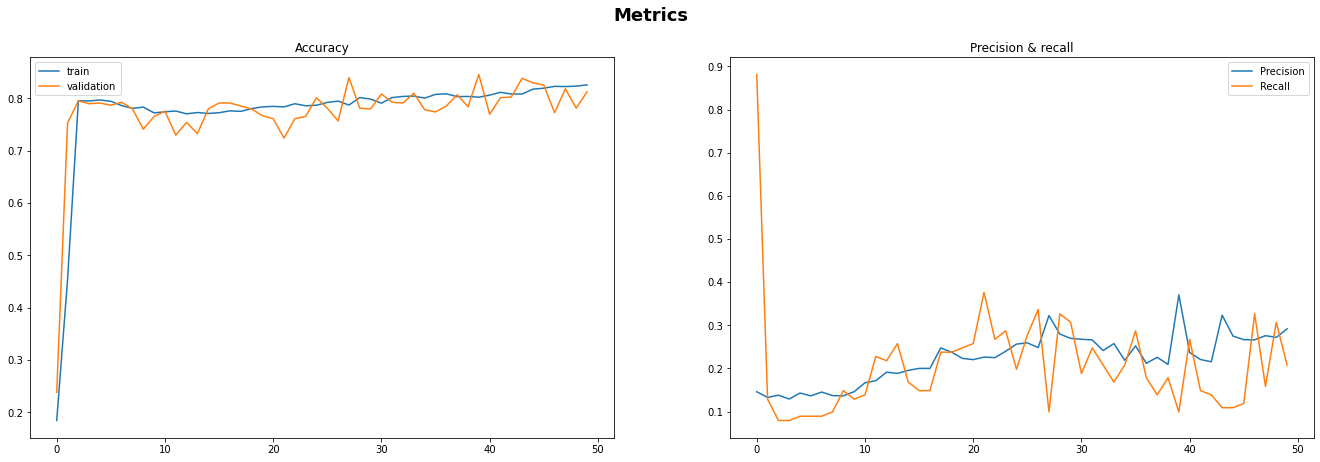

In [11]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(23, 7))

ax1.plot(history_rec.history['accuracy'], label='train')
ax1.plot(history_rec.history['val_accuracy'], label='validation')
ax1.set_title('Accuracy')
ax2.plot(history_rec.history['val_precision'], label='Precision')
ax2.plot(history_rec.history['val_recall'], label='Recall')
ax2.set_title('Precision & recall')
#ax2.plot(history.history['val_true_positives'], label='True positives')

plt.suptitle('Metrics', fontsize=18, fontweight='bold')
ax1.legend()
ax2.legend()
plt.show()

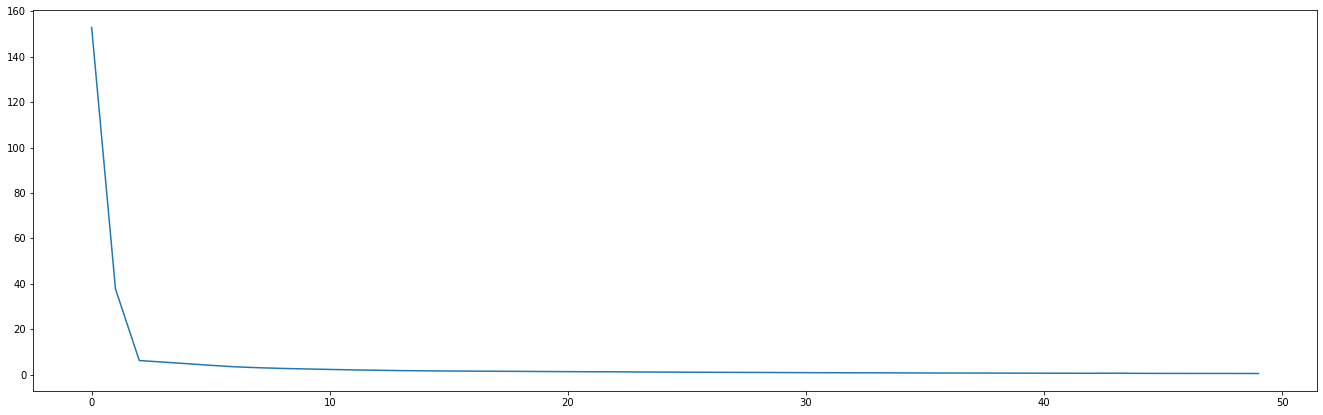

Min loss: 0.5458582043647766


In [14]:
plt.figure(figsize=(23,7))

plt.plot(history_rec.history['loss'], label='loss')
plt.show()
print('Min loss:',min(history_rec.history['loss']))

In [15]:
y_pred = model_rec.predict(x_test)
#y_pred

In [16]:
import numpy as np

threshold = 0.5
y_pred = np.where(y_pred<=threshold, 0, 1)



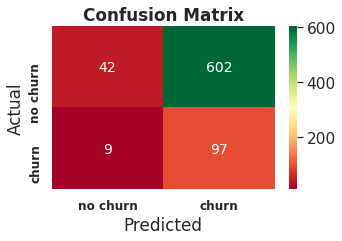


Classification report:
               precision    recall  f1-score   support

           0       0.82      0.07      0.12       644
           1       0.14      0.92      0.24       106

    accuracy                           0.19       750
   macro avg       0.48      0.49      0.18       750
weighted avg       0.73      0.19      0.14       750



In [17]:
plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
print_classification_report(y_test, y_pred)

In [18]:
print_classification_report(y_test, y_pred)


Classification report:
               precision    recall  f1-score   support

           0       0.82      0.07      0.12       644
           1       0.14      0.92      0.24       106

    accuracy                           0.19       750
   macro avg       0.48      0.49      0.18       750
weighted avg       0.73      0.19      0.14       750



epochs = 20



model = Sequential()
model.add(Dense(64,kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(input_shape,), activation='relu' ))
model.add(Dropout(rate=0.4))
model.add(Dense(8,kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(1, activation='sigmoid'))
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay( 0.001,
      decay_steps=(x_train.shape[0]/32)*5,
      decay_rate=1,
      staircase=False)

#This time decay means for every 5 epochs the learning rate will be half of 0.001 value
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=70,restore_best_weights=True)]


model.compile(loss = "binary_crossentropy", 
                  optimizer = get_optimizer(), 
                  metrics=['accuracy'])
    

    
    
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=get_callbacks())#, verbose=0)

plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

##  Model with best precision

In [21]:
from tensorflow.keras.optimizers import Adam

optimizer= Adam(0.0001)

model_pre = build_model(input_shape=20, hidden_shapes=[32], hidden_activation='relu',
                    opt=optimizer, dropout=0.0, loss='binary_crossentropy')

model_pre.summary()

32
Model: "DENSE_CHURN_PREDICTION"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20)]              0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 32)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [22]:
epo = 50

CB_checkpoint = ModelCheckpoint(monitor='val_precision', filepath='precision_model.hdf5', save_best_only=True, mode='max',verbose=1)


history_pre = model_pre.fit(x_train, y_train, epochs=epo, validation_split=0.2, callbacks=[CB_checkpoint], verbose=0)


Epoch 00001: val_precision improved from -inf to 0.14430, saving model to precision_model.hdf5

Epoch 00002: val_precision did not improve from 0.14430

Epoch 00003: val_precision did not improve from 0.14430

Epoch 00004: val_precision did not improve from 0.14430

Epoch 00005: val_precision did not improve from 0.14430

Epoch 00006: val_precision improved from 0.14430 to 0.14655, saving model to precision_model.hdf5

Epoch 00007: val_precision did not improve from 0.14655

Epoch 00008: val_precision improved from 0.14655 to 0.14783, saving model to precision_model.hdf5

Epoch 00009: val_precision did not improve from 0.14783

Epoch 00010: val_precision did not improve from 0.14783

Epoch 00011: val_precision did not improve from 0.14783

Epoch 00012: val_precision improved from 0.14783 to 0.14912, saving model to precision_model.hdf5

Epoch 00013: val_precision did not improve from 0.14912

Epoch 00014: val_precision did not improve from 0.14912

Epoch 00015: val_precision did not i

In [23]:
# Load best recall modell
model_pre.load_weights('precision_model.hdf5')

model_pre.evaluate(x_test, y_test)

24/24 [==============================] - 0s 1ms/step - loss: 0.7311 - accuracy: 0.8160 - precision: 0.2576 - recall: 0.1604


[0.7311309576034546,
 0.8159999847412109,
 0.25757575035095215,
 0.1603773534297943]

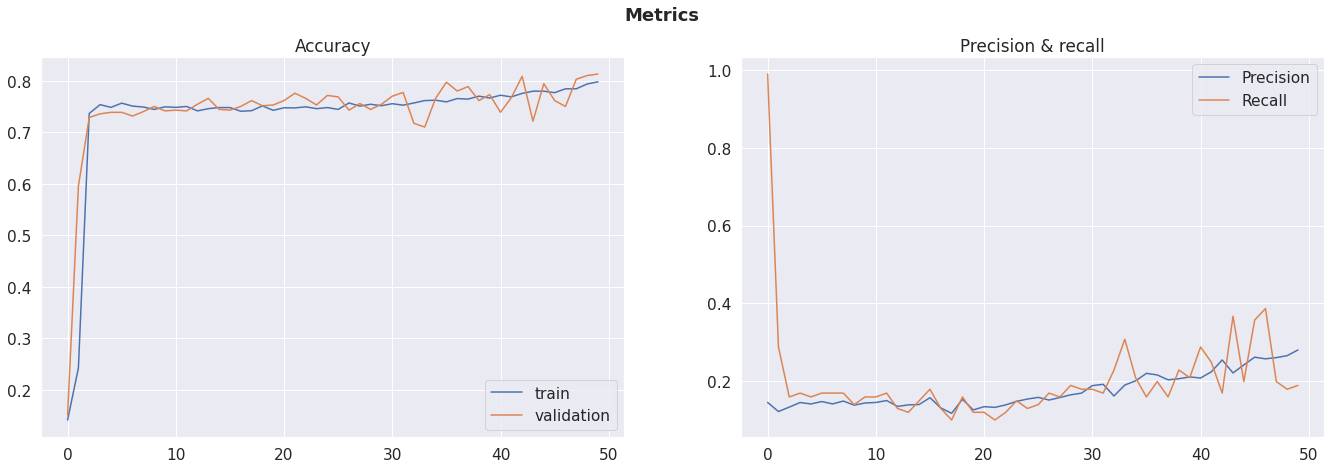

In [24]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(23, 7))

ax1.plot(history_pre.history['accuracy'], label='train')
ax1.plot(history_pre.history['val_accuracy'], label='validation')
ax1.set_title('Accuracy')
ax2.plot(history_pre.history['val_precision'], label='Precision')
ax2.plot(history_pre.history['val_recall'], label='Recall')
ax2.set_title('Precision & recall')


plt.suptitle('Metrics', fontsize=18, fontweight='bold')
ax1.legend()
ax2.legend()
plt.show()

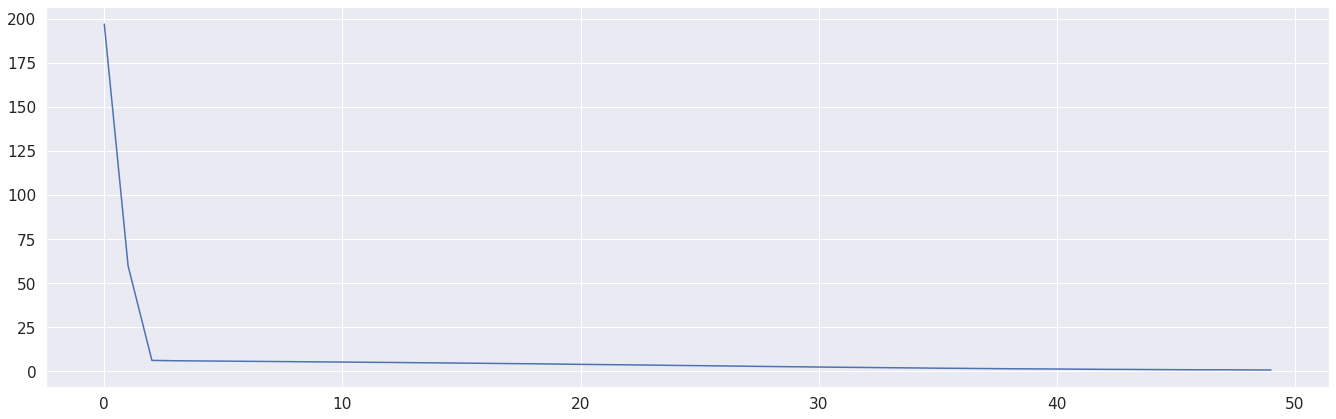

Min loss: 0.7867615818977356


In [30]:
plt.figure(figsize=(23,7))

plt.plot(history_pre.history['loss'], label='loss')
plt.show()
print('Min loss:',min(history_pre.history['loss']))

In [31]:
y_pred = model_pre.predict(x_test)
#y_pred

In [32]:
threshold = 0.5
y_pred = np.where(y_pred<=threshold, 0, 1)

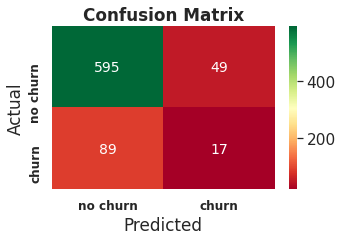


Classification report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       644
           1       0.26      0.16      0.20       106

    accuracy                           0.82       750
   macro avg       0.56      0.54      0.55       750
weighted avg       0.78      0.82      0.80       750



In [33]:
plot_confusion_matrix(y_test, y_pred, cmap='RdYlGn', normalize=None)
print_classification_report(y_test, y_pred)